# Perplexity-based subsampling of a dataset


In [6]:
%matplotlib inline

import lzma
import json
import tarfile

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use('ggplot')
#plt.style.use('bmh')
plt.style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = (14,8)

In [2]:
plt.rcParams.update({'font.size': 12})

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
from typing import List, Tuple

In [12]:
data = []
with open("../scores/culturax_da.jsonl") as f:
    for line in f:
        data.append(json.loads(line)["perplexities"]["wikipedia_pp"])

data = np.array(data)
len(data)

1000000

In [14]:
qr = np.quantile(data, [0.25, 0.50, 0.75])
qr


array([397.975, 503.3  , 648.2  ])

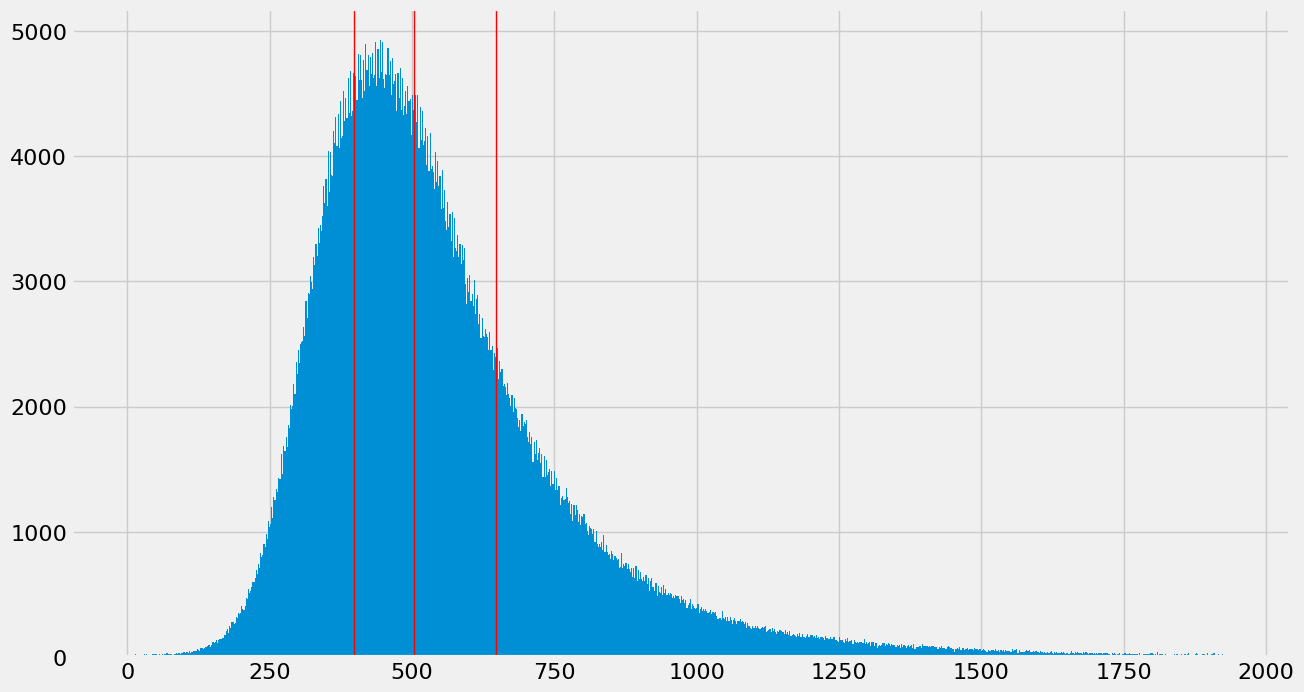

In [15]:
fig, ax = plt.subplots()
ax.hist(data, bins=1000, range=[0, qr[2]*3]);
#ax.set_title("perplexity for a random sample of mC4-es (P95 of 44M values)");
#ax.get_yticklabels().set_fontsize(9)
for q in qr:
    ax.axvline(q, c='r', lw=1)


## Testing gaussian sampling

In [16]:
from scipy.stats import norm, uniform

In [17]:
pa = 0.15  # probability fraction we will want below Xa -- should be less than 0.25
pb = 0.10  # probability fraction over Xb -- should be less than 0.25

In [18]:
# Standard deviation
sdev = (qr[0] - qr[2]) / (norm.ppf(pa) - norm.ppf(1-pb))

# Mean
mean = qr[0] - norm.ppf(pa)*sdev


In [19]:
x = np.linspace(0, qr[2]+qr[0], 5000)
y = norm.cdf(x, loc=mean, scale=sdev)

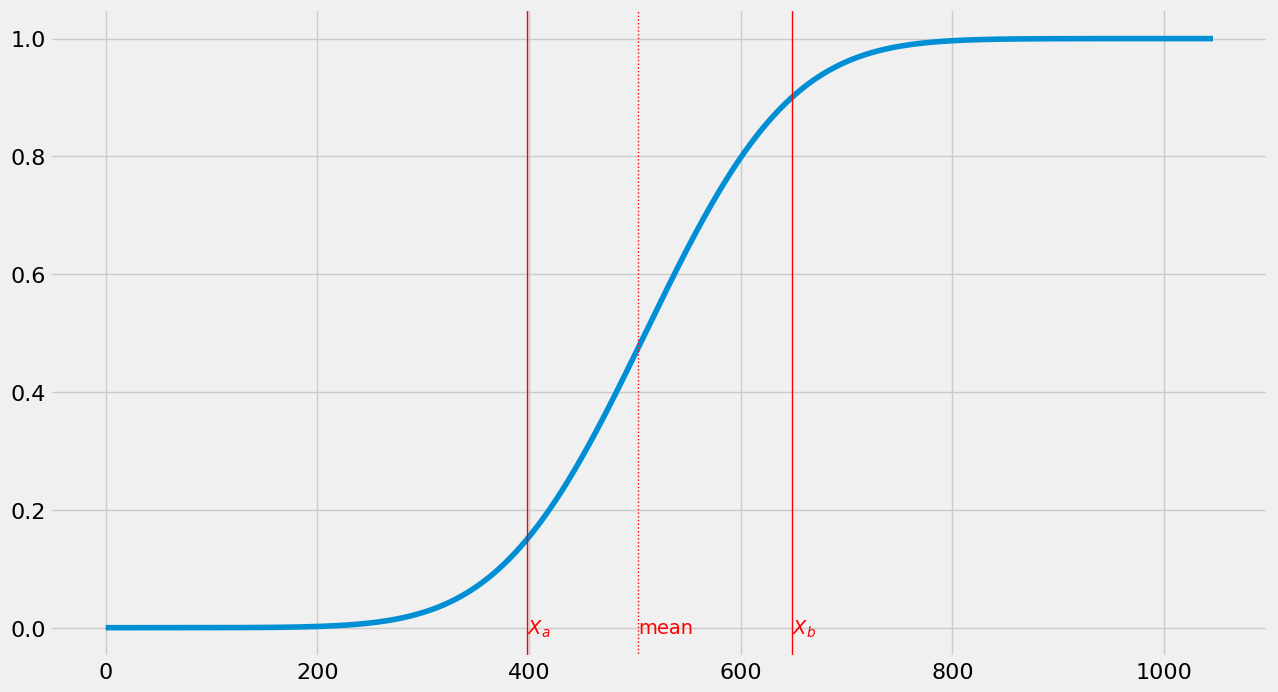

In [20]:
fig, ax = plt.subplots()
ax.plot(x, y);
for q, t, s in zip(qr, ["$X_a$", "mean", "$X_b$"], ["-", ":", "-"]):
    ax.axvline(q, c='r', lw=1, ls=s)
    ax.text(q, -0.01, t, color="r")

In [21]:
# Check the probabilities for the regions delimited by Xa & Xb
norm.cdf(qr[0], loc=mean, scale=sdev), norm.cdf(qr[2], loc=mean, scale=sdev)

(0.1499999999999999, 0.8999999999999999)

In [22]:
def plot_quartiles(ax: plt.Axes):
    for q, s in zip(qr, ["-", ":", "-"]):
        ax.axvline(q, c='r', lw=1, ls=s)

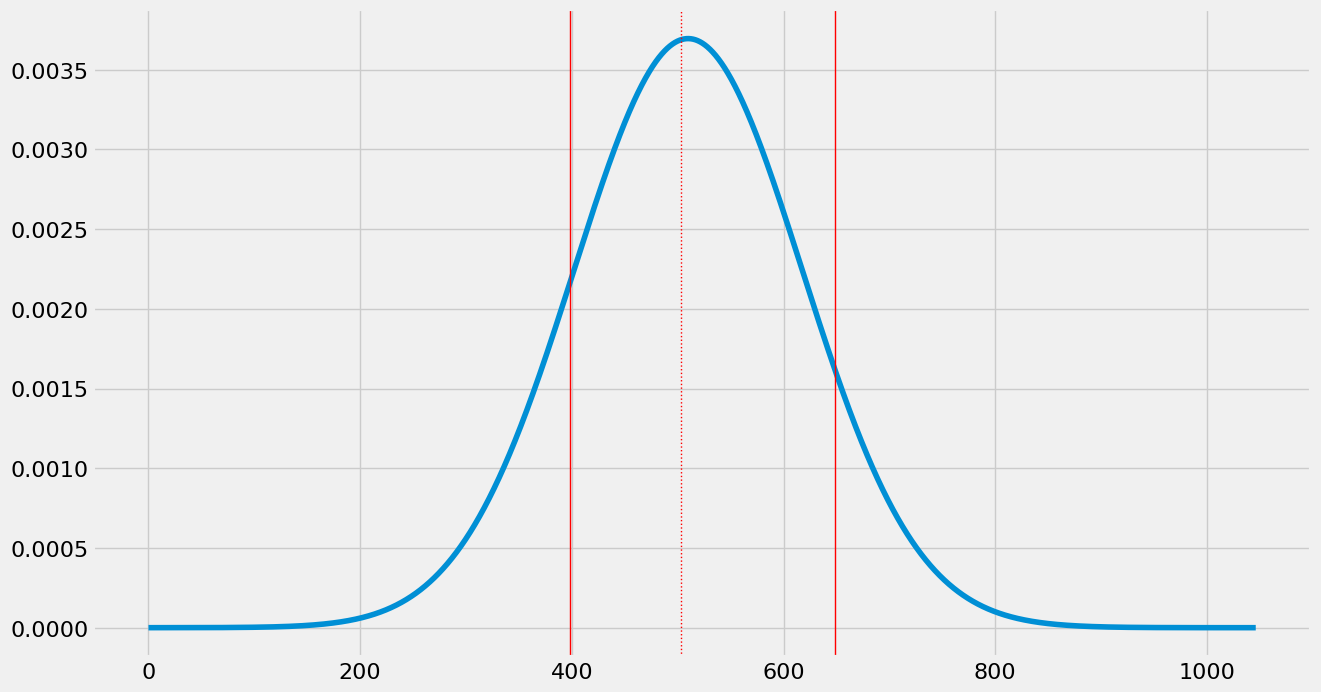

In [23]:
gauss_pdf = norm.pdf(x, loc=mean, scale=sdev)

fig, ax = plt.subplots()
ax.plot(x, gauss_pdf);
plot_quartiles(ax)

In [25]:
# area should be 1
sum(gauss_pdf)*(x[1]-x[0])

0.9999985080935955

In [26]:
pdf_max = np.max(gauss_pdf)

In [27]:
pdf_max, norm.pdf(mean, loc=mean, scale=sdev)

(0.0036956421869327907, 0.003695642737133491)

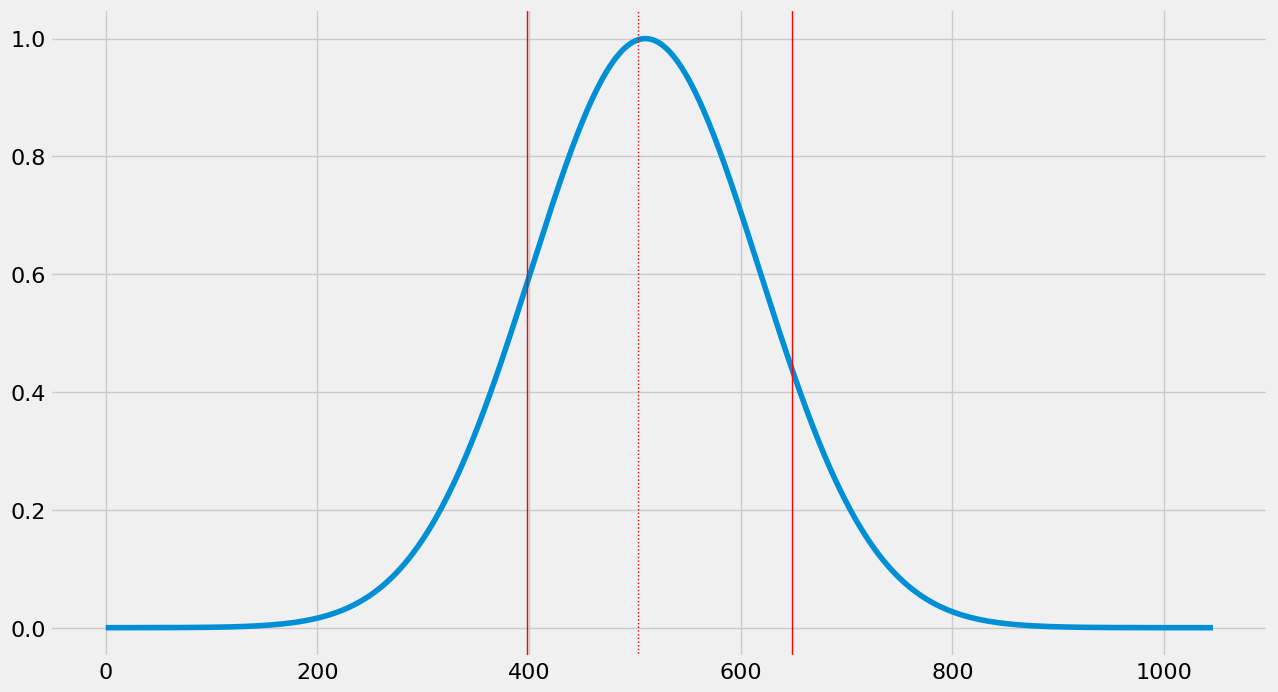

In [28]:
fig, ax = plt.subplots()
ax.plot(x, gauss_pdf/pdf_max);
plot_quartiles(ax)

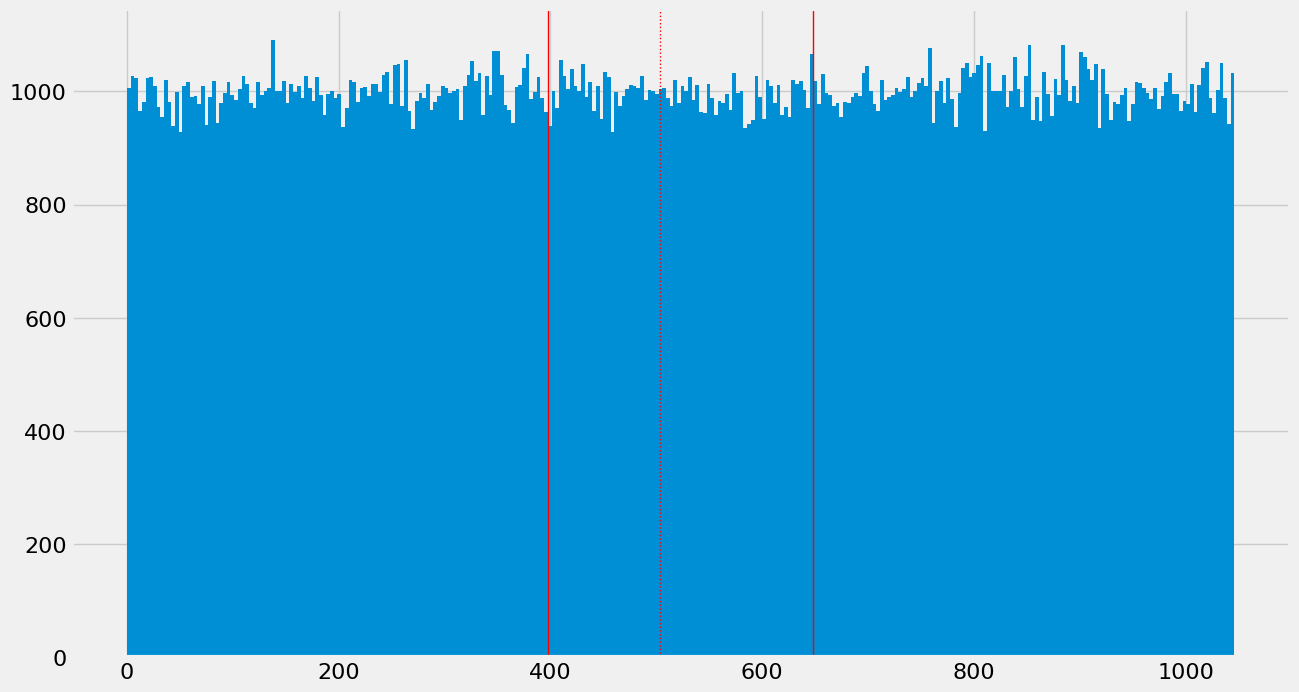

In [29]:
interval = [0, qr[2]+qr[0]]
width = interval[1] - interval[0]

# we generate random data on the interval 
data_unif = uniform.rvs(*interval, 300000)

# Let's plot the distribution for the test data. Should be flat
fig, ax = plt.subplots()
ax.hist(data_unif, bins=300);
plot_quartiles(ax)



In [30]:
def subsample_gauss(data: np.ndarray, mean: float, sdev: float, norm_factor: float) -> np.ndarray:
    """
    Vectorized subsampling: process the whole dataset
    """
    # Create the gaussian weight for each data point
    p = norm.pdf(data, loc=mean, scale=sdev)/norm_factor
    #print(p)
    # Subsample data with probability according to the weight
    return data[ uniform.rvs(size=len(p)) < p ]

In [31]:
ratio = 1/(width*pdf_max)
ratio


0.2586459880256598

In [32]:
data_unif_sub = subsample_gauss(data_unif, mean, sdev, pdf_max)

In [33]:
len(data_unif_sub)/len(data_unif)

0.25728

In [34]:
def check_regions(data: np.ndarray):
    ra = len(data[data < qr[0]]) / len(data)
    print("Probability mass below Pa:", ra)
    rb = len(data[data > qr[2]]) / len(data)
    print("Probability mass above Pb:", rb)

In [35]:
check_regions(data_unif_sub)

Probability mass below Pa: 0.15082141376451078
Probability mass above Pb: 0.10037054311774461


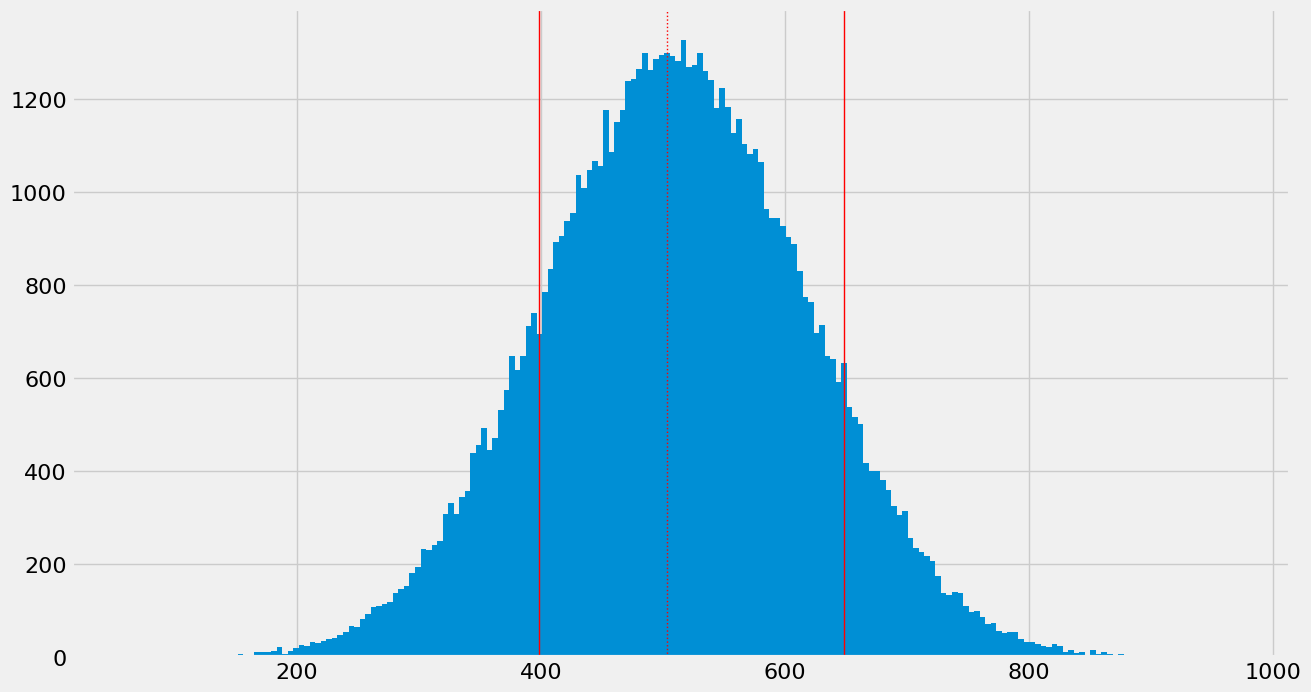

In [36]:
fig, ax = plt.subplots()
ax.hist(data_unif_sub, bins=200);
plot_quartiles(ax)


In [37]:
# Let's seek a sampling ratio of 20%
desired_sampling_ratio = 0.20

# With this desired fraction, we compute the new normalization factor
unif_norm_factor = 1/(width*desired_sampling_ratio)


In [38]:
data_unif_sub2 = subsample_gauss(data_unif, mean, sdev, unif_norm_factor)

In [40]:
# Now we have our desired sampling ratio
len(data_unif_sub2)/len(data_unif)

0.19953666666666667

In [41]:
# And the probability masses stay as before
check_regions(data_unif_sub2)

Probability mass below Pa: 0.152854112026194
Probability mass above Pb: 0.09983127578891098


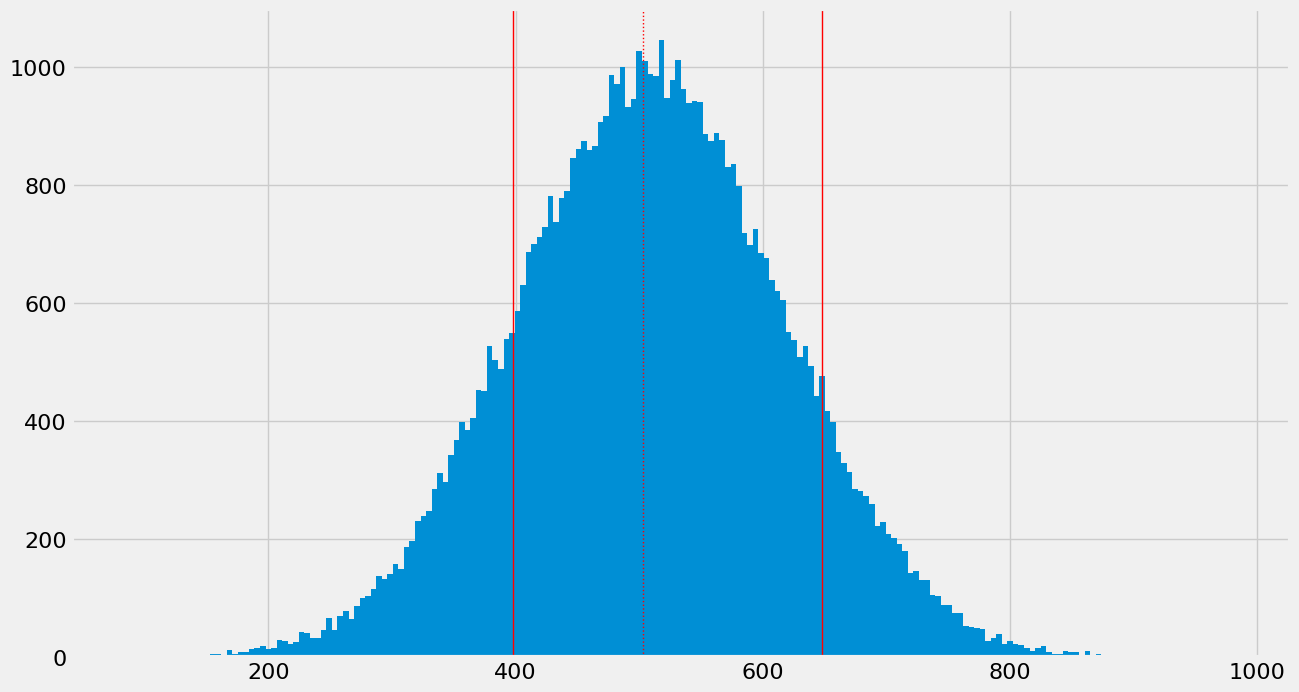

In [42]:
fig, ax = plt.subplots()
ax.hist(data_unif_sub2, bins=200);
plot_quartiles(ax)

## Applying gaussian sampling

In [54]:
# Let's seek a sampling ratio of 20%
desired_sampling_ratio = 0.20

# With this desired fraction, we compute the new normalization factor
unif_norm_factor = 1/(width*desired_sampling_ratio)

In [55]:
%%time
data_sub = subsample_gauss(data, mean, sdev, unif_norm_factor)

CPU times: user 44.1 ms, sys: 12.2 ms, total: 56.3 ms
Wall time: 54.3 ms


In [56]:
# Compute the sampling ratio we have achieved
len(data_sub)/len(data)

0.396047

In [57]:
def plot_subsample(orig: np.ndarray, sub: np.ndarray, 
                   name: str = 'Gaussian subsampling'):
    fig, ax = plt.subplots()
    if orig is not None:
        ax.hist(orig, bins=1000, range=[0, qr[2]*3]);
    ax.hist(sub, bins=1000, range=[0, qr[2]*3], color="g");
    if orig is not None:
        ax.legend(['original', 'subsampled'])
    plot_quartiles(ax)
    ax.set_title("Perplexity distribution " + ("before and after " if orig is not None else "for ") + name);

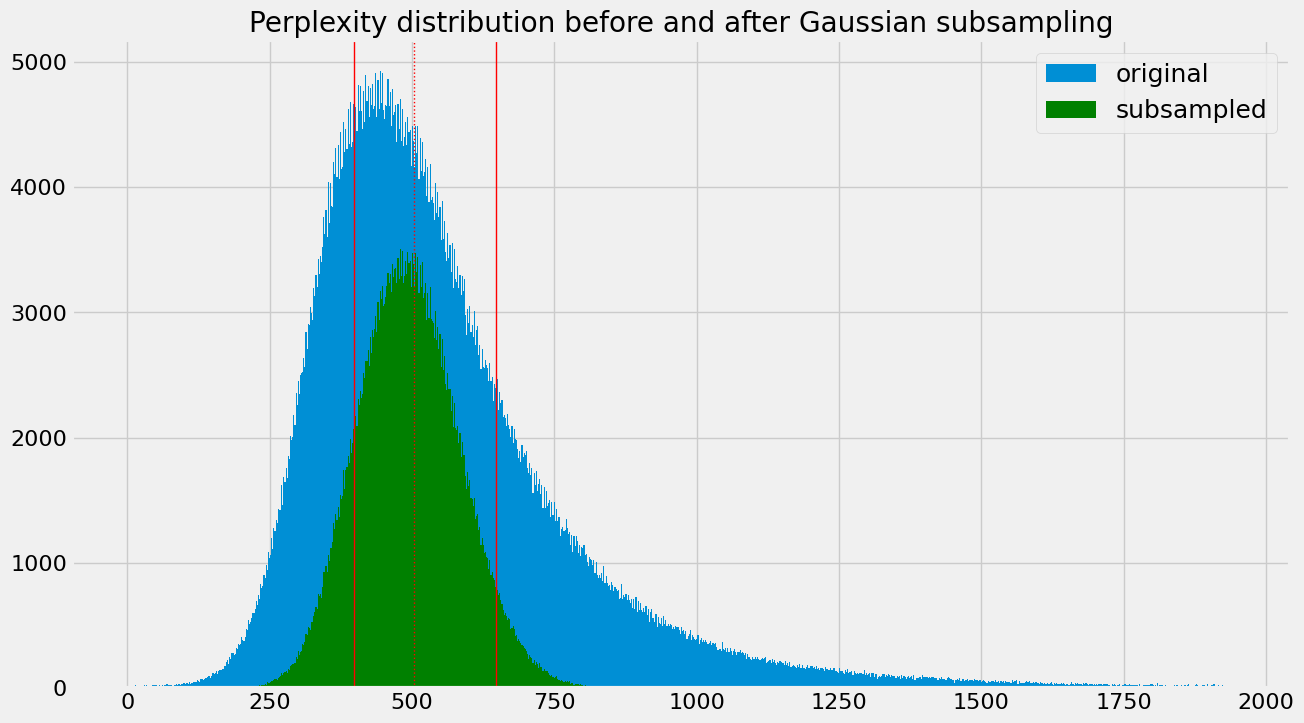

In [58]:
plot_subsample(data, data_sub)

## Using PerplexitySubsampler

In [60]:
from subsampler import PerplexitySubsampler

In [62]:
subsampler = PerplexitySubsampler(data)

In [64]:
subsampler.set(ratio=0.30, pa=0.20, pb=0.05)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 81
         Function evaluations: 156


In [66]:
subsampler.norm, subsampler.mean, subsampler.sdev

(0.006131260240020625, 488.615463864415, 124.17368632962524)